<a href="https://colab.research.google.com/github/dnevo/ImageProcessing/blob/main/ImageProcessingRecitation_10_HoughTransform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import os
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import PIL
from scipy.signal import convolve

In [ ]:
GITHUB_PATH = 'https://raw.githubusercontent.com/dnevo/ImageProcessing/main/images/'

def read_file(file_name:str, file_path:str=GITHUB_PATH) -> np.ndarray:
    '''
    Accept an image file name (defaulty located in GitHub) and return the image
    in a numpy array.

    Args:
        file_name: the file name
        file_path: the file path.. Default value is Doron's Github repo.

    Returns:
        the image converted into a Numpy array.
    '''
    file_path = os.path.join(file_path, file_name)
    response = requests.get(file_path)
    fp = BytesIO(response.content)

    img_pil = PIL.Image.open(fp)
    return np.array(img_pil, dtype='int16')

In [ ]:
def plot_images(img1:np.array, img2:np.array):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
    axes[0].imshow(img1,  cmap='gray')
    axes[1].imshow(img2,  cmap='gray')

#10. Hough Transform

##10.1 Line Detection

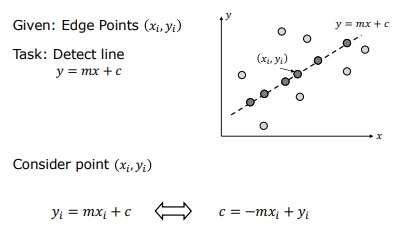

**The concept**

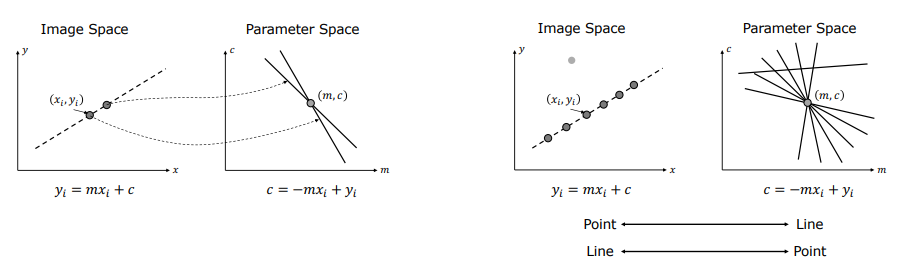

**Line detection algorithm**

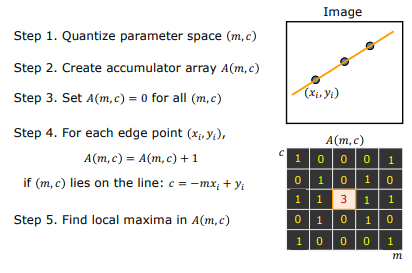

**Note:** the above is problematic for vertical lines (why?). Alternative is using $r=x \cos \theta+y \sin \theta$

##10.2 Circle Detection

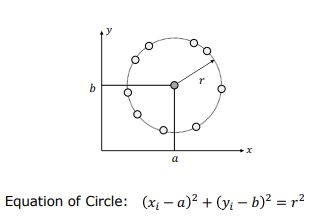

Given a set of edges, the three parameters we are interested in finding are $a$, $b$, and $r$.

###10.2.1 radius $r$ is known

**Let us make the problem easier by assuming that we know the radius $r$ of the circle we are trying to find.**

**If radius $r$ is known: Accumulator Array: $M(a,b)$.**

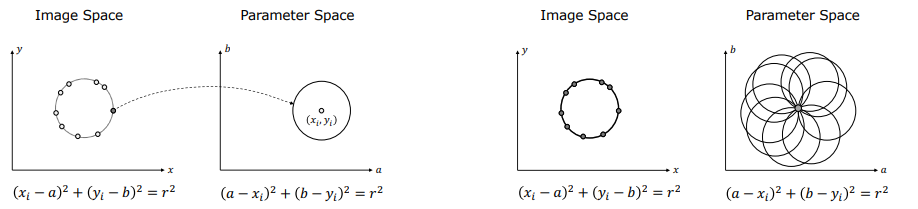

###10.2.2 radius $r$ is unknown

If radius $r$ is NOT known: Accumulator Array: $M(a,b,r)$:

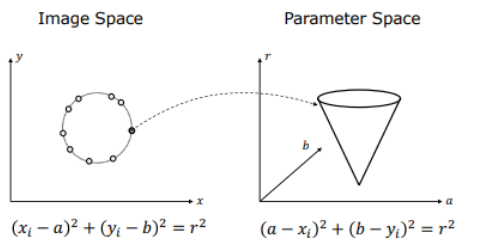

**Naive algorithm:**
1. create an edges matrix - using Canny Canny Edge Detector.
2. Go over all the pixels. for each edge pixel, check all possible circles:
```python
max_r = round(min(ncols, nrows) / 2)
M = zeros(ncols, nrows, max_r)
for x in range(ncols):
    for y in range(nrows):
        ''' The pixel is part of an edge, check if it belongs to a circle'''
        if edges[y, x] ==1:
            ''' Check all the possible centers for the circle'''
            for a in range(ncols):
                for b in range(nrows):
                    ''' Determine the radius according to the distance between
                    the edge pixel and the current center'''
                    r = round(sqrt((a - x)**2 + (b - y)**2))
                    if r <= max_r:
                        M[a, b, r] += 1
```
3. Go over all values in $M$:
  - if value < threshold, ignore it. NOTE: the threshold correlate to $r$. **Why?**
  - if value is not max of its 8 neighbours, ignore

### Q: what is the downside of this algorithm?

The complexity is $o(n^4)$

####Reducing computation

In addition to the location of each edge, $(x_i,y_i)$, Canny Edge Detector provide also as output, the direction of the gradient: $tan(\varphi_i)$.

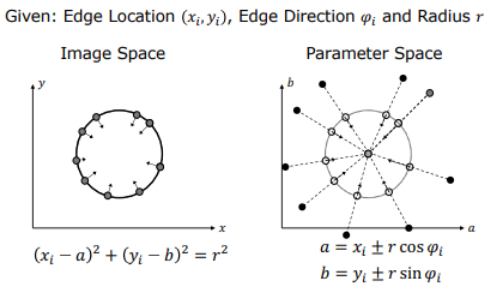

Therefore, instead of going over all the possible $(x_i,y_i)$, it is enough to go over the those which are in the gradient direction.

$tan(\varphi)=S_x/S_y$ is the slope of odd line: therefore we can loop over $x_i$ to the 2 directions, and increment $y_i$ by $tan(\varphi)$.

Note that in case $tan(\varphi)>1$, we can "miss" pixels - in that case instead of running on $x_i$, we will run on $y_i$ and we will update $x_i$ by $1/tan(\varphi)$

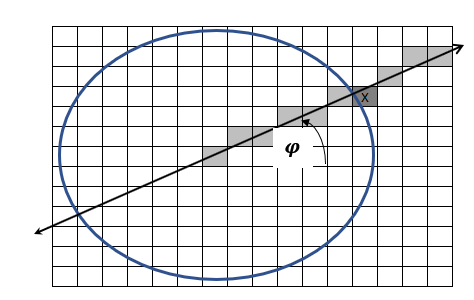

##10.3 Hough Transform using OpenCV

In [ ]:
img = read_file('balls4.tiff').astype('uint8')

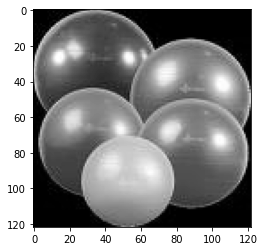

In [ ]:
plt.imshow(img, cmap='gray');

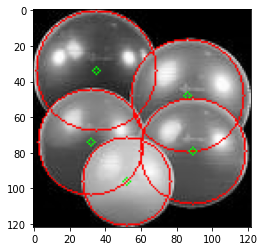

In [ ]:
imgc = np.dstack((img, img, img))
import cv2
circles = cv2.HoughCircles(image=img,method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,
                            param1=100,param2=41,minRadius=4,maxRadius=200).astype('uint16')
for i in circles[0,:]:
    cv2.circle(img=imgc,center=(i[0],i[1]),radius=i[2],color=(255,0,0),thickness=1)   # draw the outer circle
    cv2.circle(img=imgc,center=(i[0],i[1]),radius=2,color=(0,255,0),thickness=1)  # draw the center of the circle
plt.imshow(imgc, cmap='gray');

##10.5 The algorithm

**Step 1: apply Edge Detection**
- inputs: `img, t_low, t_high`
- outputs:
  - `edges`: the edges matrix
  - `tg_theta`: for speedup

**Step 2: create the count matrix (centers(cx, cy) per radius (r) counters)**
- set `r_min` to minimal radius of a circle (e.g. 14).
- set `r_max` to maximum radius of circle (e.g. half of shorter image edge).
- init `count` matrix with zeros. shape: (`img_ncols, img_nrows, r_max)`
- scan `edges` matrix. for each `edges[x,y]`:
  - `if edges[x,y] == 0: continue`
  - `if abs(tg_theta[x,y]) <= 1:`
    - note: `count[cx, cy, r]` is the center of potential circle with radius r.
    - scan `cx` in the range `(max(x - r_max, 0), min(x + r_max, img_ncols))`
      - `cy = round(tg_theta[y, x] * (cx - x) + y)`
      - `r = round(np.sqrt((cx - x)**2 +(cy - y)**2))`
      - `if 0 < cy < img_nrows and 0 < r < r_max:`
        - `count[cx, cy, r] +=1`
  - `else: # (abs(tg_theta[x,y]) > 1)`
    - scan `cy` in the range `(max(y - r_max, 0), min(y + r_max, img_nrows))`
      - `cx = round((cy-y)/tg_theta[y, x] + x)`
      - `r = round(np.sqrt((cx - x)**2 +(cy - y)**2))`
      - `if 0 < cx < img_ncols and 0 < r < r_max:`
        - `count[cx, cy, r] +=1`

**Step 3: locate the real circles**
  - smooth the `count` matrix using 3d convolution with mean kernel shaped (5,5,5)
  - init `img_c` with zeros: shape same as `img`
  - init `circles=[]`
  - scan count matrix (3 nested loops: `cx,cy,r` with ranges `img_ncols, img_nrows, (r_min,r_max)`
    - `if count[cx, cy, r] <= threshold: continue` :i.e. ignore it (threshold correlate to  `r` - e.g. `r/25`)
    - perform Non Max Suppression:
      - if value is not  max of its neighbours, ignore it (`D` is a hyperparamer for neighborhood size  (e.g. `D=15`):
                `neigbours = count[
                    max(cx-D, 1):min(cx+D, img_ncols),
                    max(cy-D, 1):min(cy+D, img_nrows),
                    max(r-D, r_min):min(r+D, r_max)]`
                `if count[cx, cy, r] < np.max(neibours): continue`
      - we located a circle with center `(cx,cy)` and radius `r` on `img_c`:
        - `circles.append([cx, cy, r])`
        - set to ones the pixels lying on the circle:
        ```python
            theta = 0
            while theta <= 2*np.pi:
                pt = np.round(np.array([cx,cy]) + np.array([r*np.cos(theta),r*np.sin(theta)]))
                irow = int(pt[1])
                icol = int(pt[0])
                if 0 < irow < img_nrows and 0 < icol < img_ncols:
                    img_c[irow, icol] = 1
                theta = theta + 1/r        
```

`return img_c, circles`
